In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import shutil

import cv2

In [3]:
from datetime import datetime, timedelta

def is_valid_date(date_string):
    try:
        # Попробуем преобразовать строку в дату
        datetime.strptime(date_string, '%Y-%m-%d')
        return True
    except ValueError:
        # Если произошла ошибка, значит строка не является датой
        return False 

In [4]:
def display_images_side_by_side(images, titles=None, max_images_per_row=4):
    num_images = len(images)
    
    if num_images == 0:
        print("Нет изображений для отображения.")
        return
    
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # округление вверх
    num_cols = min(num_images, max_images_per_row)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    if num_rows == 1:
        axes = np.array([axes])
    if num_cols == 1:
        axes = np.array([[ax] for ax in axes])
    
    axes = axes.reshape(num_rows, num_cols)
    
    for i, (ax, image) in enumerate(zip(axes.flat, images)):
        if image.ndim == 2:  # grayscale image
            ax.imshow(image, cmap='gray')
        else:  # RGB image
            ax.imshow(image)
        ax.axis('off')
        if titles is not None and i < len(titles):
            ax.set_title(titles[i])
    
    # Удаление лишних осей
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes.flat[j])
    
    plt.tight_layout()
    plt.show()

In [5]:
def randomize_crop_coords(x1, y1, x2, y2, num = 20):
    x1 += np.random.randint(-num, num)
    y1 += np.random.randint(-num, num)
    y2 += np.random.randint(-num, num)
    x2 += np.random.randint(-num, num)
    return x1, y1, x2, y2

### Создаем тренировочный датасет на одной камере

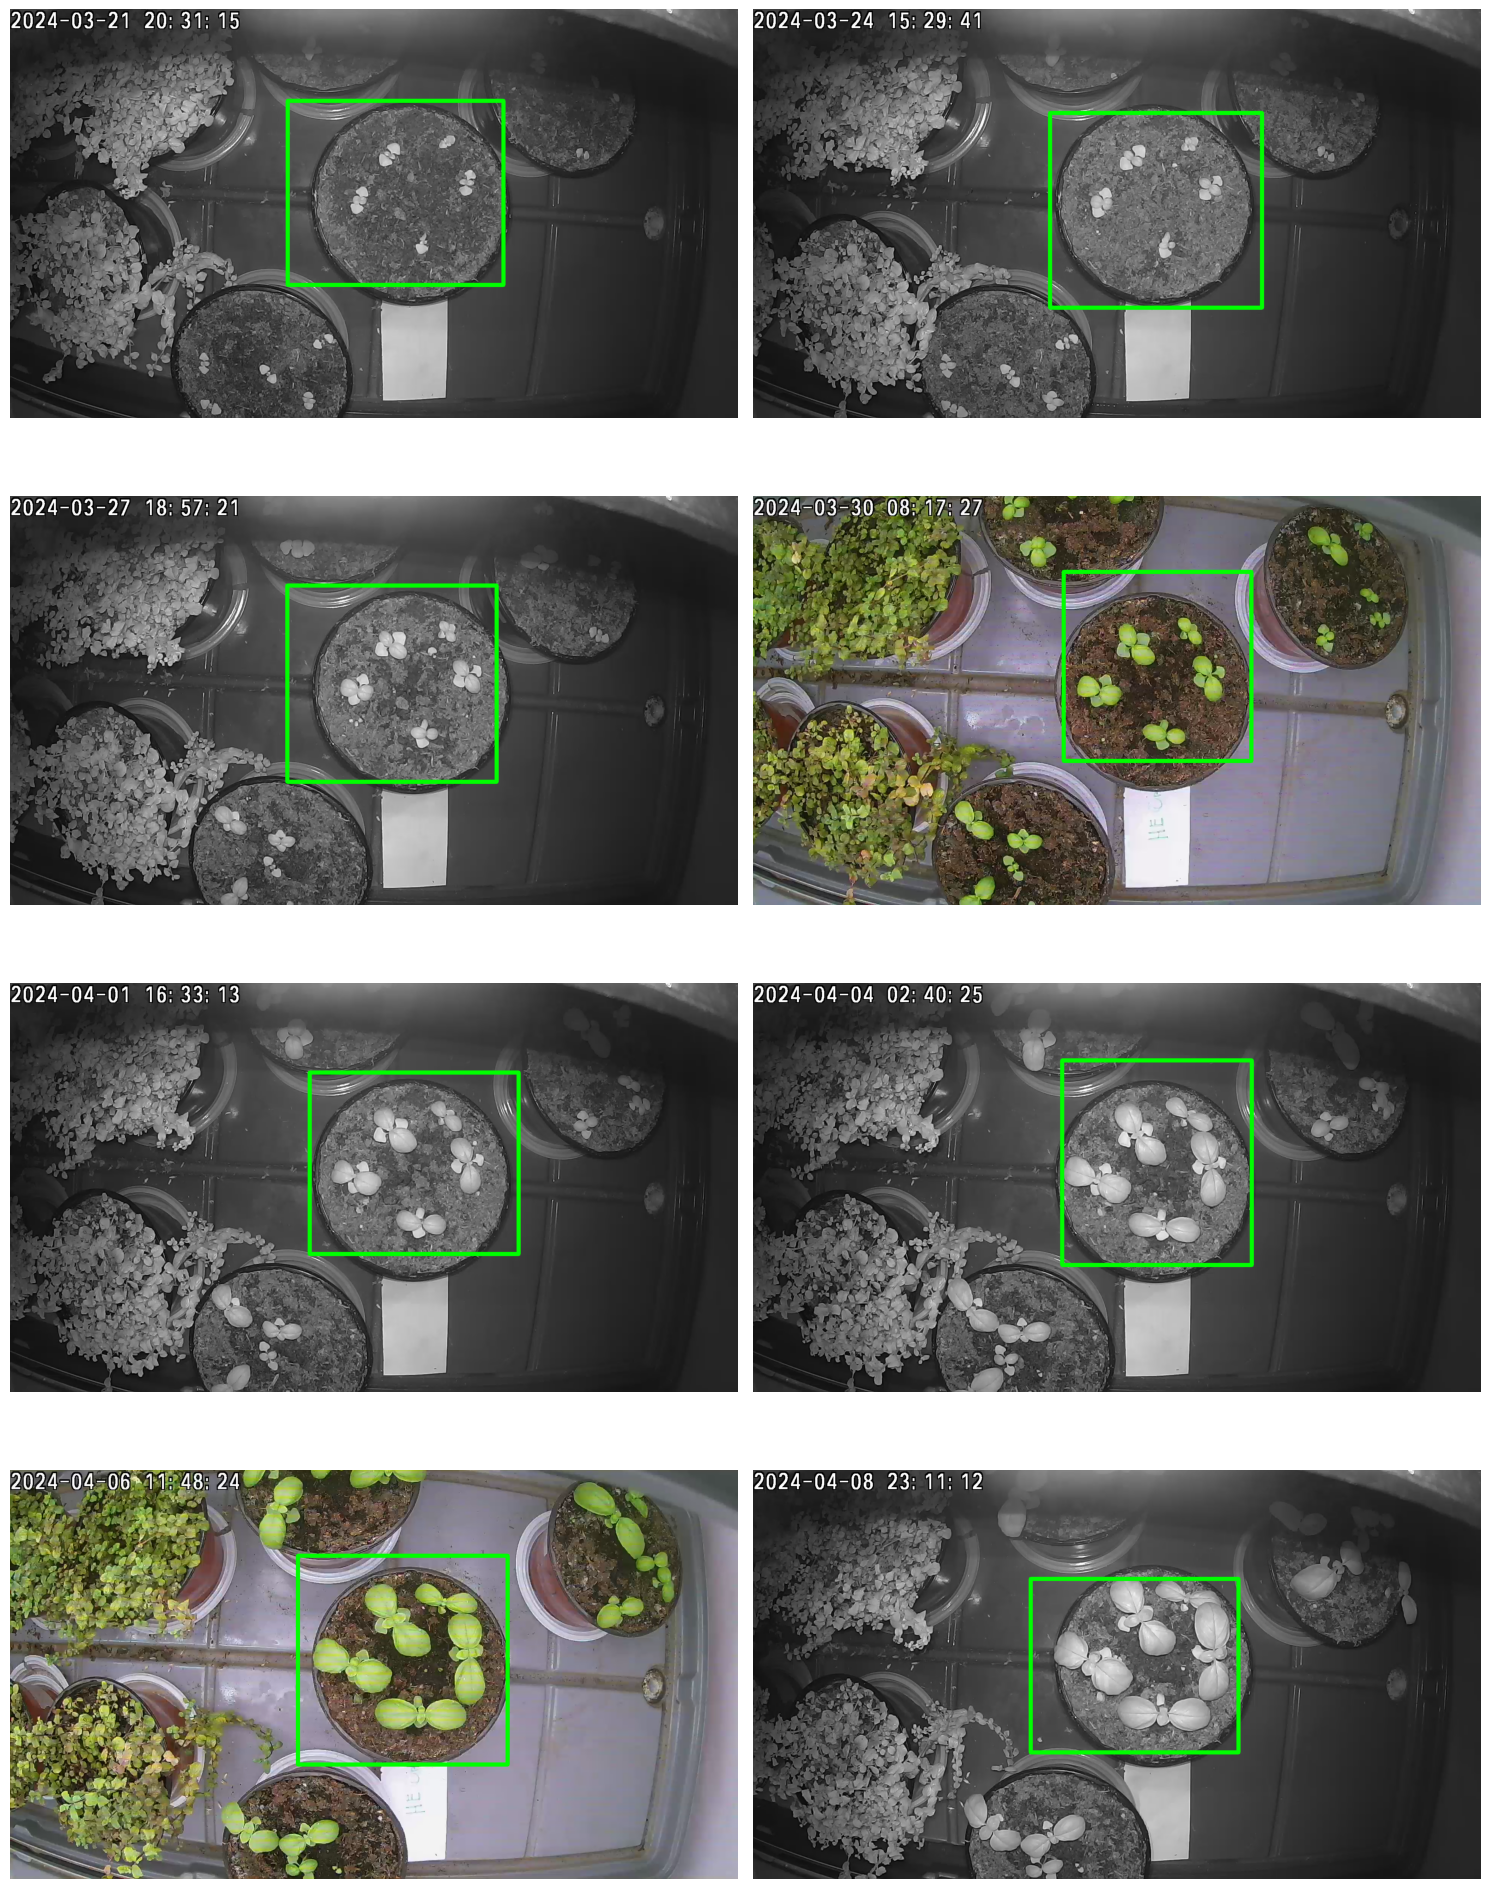

In [11]:
exp = "exp20240321"
cam = "CAM_2_3" # train
data_path = Path("/Volumes/Black/Data")/exp/cam
dates_paths = [date for date in list(data_path.iterdir()) if is_valid_date(str(date.name))]

images_paths = []
for date_path in dates_paths:
    images_date_paths = [image_path for image_path in list((date_path/"original").iterdir()) if image_path.name.endswith("png") and not image_path.name.startswith("._")]
    for image_path in images_date_paths:
        images_paths.append(image_path)

images_nums_for_visualize = np.linspace(0, len(images_paths)-1, 8).astype(int).tolist()
# x1, y1, x2, y2 = 580, 180, 1140, 720 # CAM_2_3
x1, y1, x2, y2 = 780, 240, 1320, 750 # CAM_1_3
images = []
for i in images_nums_for_visualize:
    x1_rand, y1_rand, x2_rand, y2_rand = randomize_crop_coords(x1, y1, x2, y2, num=50)
    # x1_rand, y1_rand, x2_rand, y2_rand = x1, y1, x2, y2
    image_path = images_paths[i]
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image_rect = cv2.rectangle(image_rgb.copy(), (x1, y1), (x2, y2), (0,255,0), 10)
    image_rect = cv2.rectangle(image_rgb.copy(), (x1_rand, y1_rand), (x2_rand, y2_rand), (0,255,0), 10)
    images.append(image_rect)
    
display_images_side_by_side(images, max_images_per_row=2)    

In [43]:
dataset_name = "instance_segmentation_basil"
dataset_path = Path("./../datasets") / dataset_name 
print(dataset_path.exists())

True


In [105]:
train_dataset_len = 50
images_nums_for_visualize = np.linspace(0, len(images_paths)-1, train_dataset_len).astype(int).tolist()
x1, y1, x2, y2 = 580, 180, 1140, 720
images = []
for i in images_nums_for_visualize:
    x1_rand, y1_rand, x2_rand, y2_rand = randomize_crop_coords(x1, y1, x2, y2, num=50)
    image_path = images_paths[i]
    image = cv2.imread(image_path)
    # image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image[y1_rand:y2_rand, x1_rand:x2_rand]
    new_image_path = dataset_path / "images" /image_path.name
    cv2.imwrite(str(new_image_path), image)
    
# display_images_side_by_side(images, max_images_per_row=2)    

### Создаем тестовый датасет на 3 камерах

[1, 2]

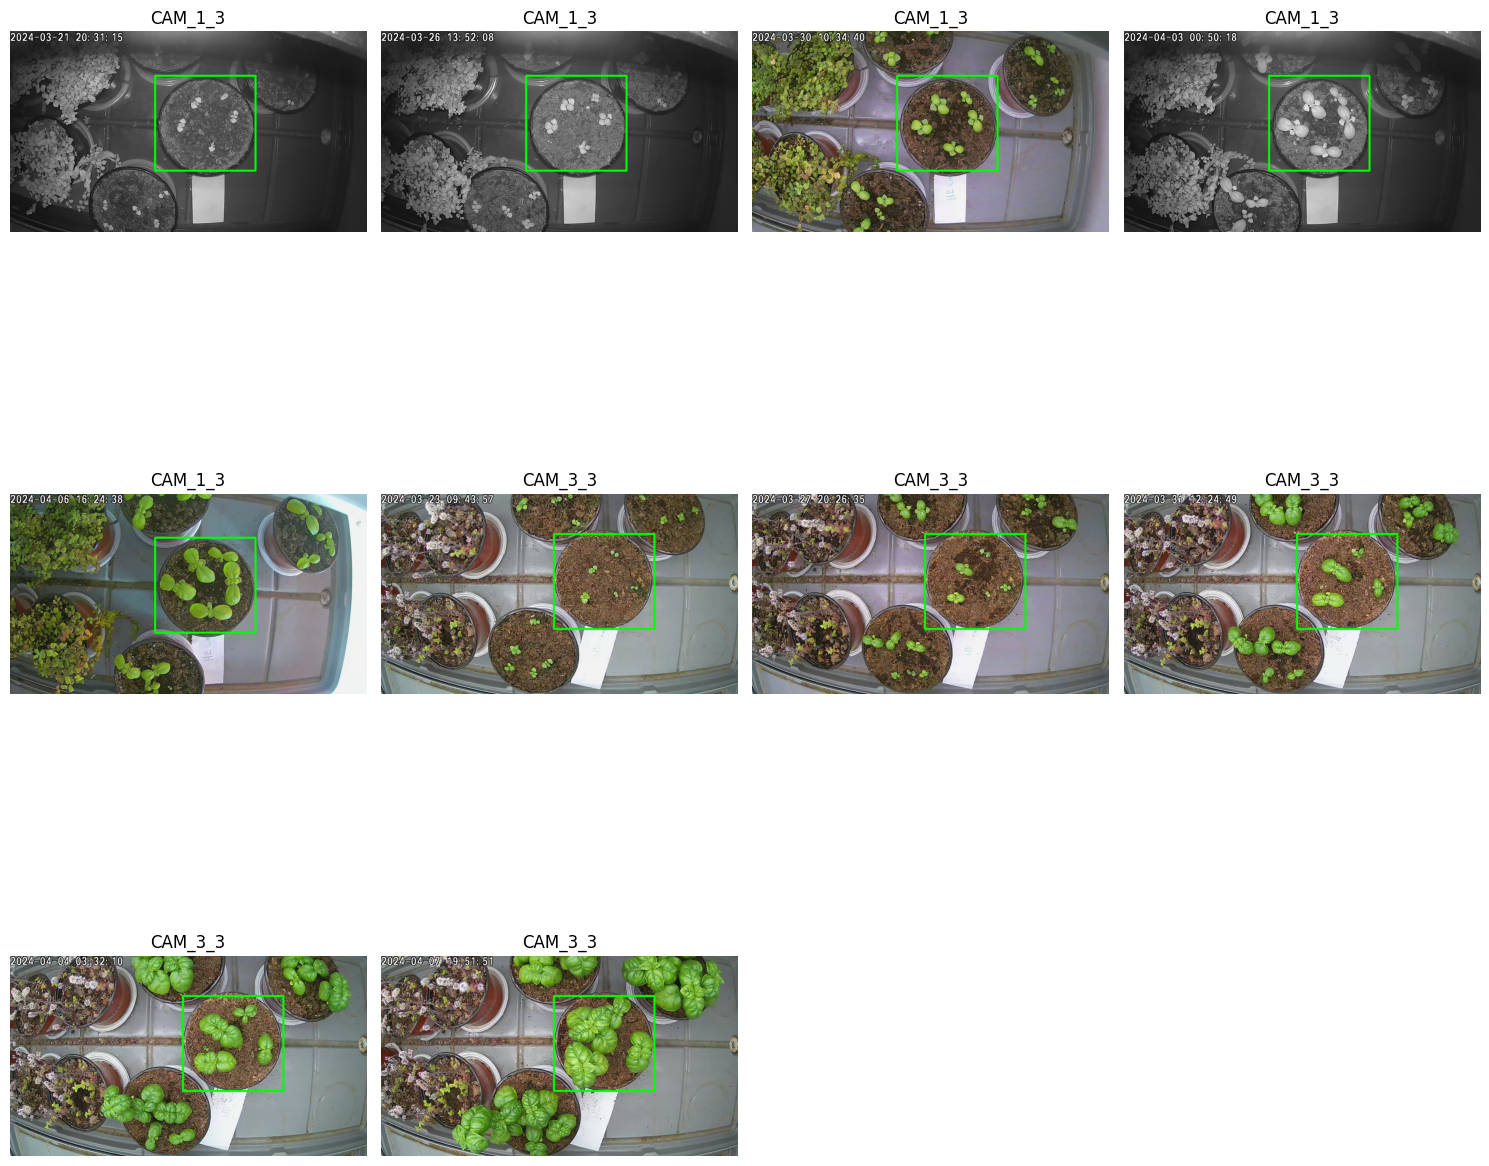

In [39]:
exp = "exp20240321"
test_cams = ["CAM_1_3", "CAM_3_3", "CAM_4_3"]

exp_path = Path("/Volumes/Black/Data")/exp
images_paths = []

for cam in test_cams:
    dates_paths = [date for date in list((exp_path/cam).iterdir()) if is_valid_date(str(date.name))]
    for date_path in dates_paths:
        images_date_paths = [image_path for image_path in list((date_path/"original").iterdir()) if image_path.name.endswith("png") and not image_path.name.startswith("._")]
        images_paths += images_date_paths

images_nums_for_visualize = np.linspace(0, len(images_paths)-1, 15).astype(int).tolist()
crop_values = {
    "CAM_1_3" : {
        "x1" : 780,
        "y1" : 240,
        "x2" : 1320,
        "y2" : 750
    },
    "CAM_3_3" : {
        "x1" : 930,
        "y1" : 220,
        "x2" : 1470,
        "y2" : 730
    },
    "CAM_4_3" : {
        "x1" : 795,
        "y1" : 210,
        "x2" : 1320,
        "y2" : 750
    },
}
images = []
images_names = []
for i in images_nums_for_visualize[:10]:
# for i in images_nums_for_visualize:
    image_path = images_paths[i]
    image_cam = image_path.parent.parent.parent.name
    x1, y1, x2, y2 = crop_values[image_cam]["x1"], crop_values[image_cam]["y1"], crop_values[image_cam]["x2"], crop_values[image_cam]["y2"]
    # x1_rand, y1_rand, x2_rand, y2_rand = randomize_crop_coords(x1, y1, x2, y2, num=50)
    x1_rand, y1_rand, x2_rand, y2_rand = x1, y1, x2, y2
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image_rect = cv2.rectangle(image_rgb.copy(), (x1, y1), (x2, y2), (0,255,0), 10)
    image_rect = cv2.rectangle(image_rgb.copy(), (x1_rand, y1_rand), (x2_rand, y2_rand), (0,255,0), 10)
    images.append(image_rect)
    images_names.append(image_cam)
    
display_images_side_by_side(images, titles=images_names, max_images_per_row=4)    

In [46]:
images = []
images_names = []
for i in images_nums_for_visualize[10:13]:
    image_path = images_paths[i]
    image_cam = image_path.parent.parent.parent.name
    x1, y1, x2, y2 = crop_values[image_cam]["x1"], crop_values[image_cam]["y1"], crop_values[image_cam]["x2"], crop_values[image_cam]["y2"]
    x1_rand, y1_rand, x2_rand, y2_rand = randomize_crop_coords(x1, y1, x2, y2, num=50)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rect = cv2.rectangle(image_rgb.copy(), (x1_rand, y1_rand), (x2_rand, y2_rand), (0,255,0), 10)

    image = image[y1_rand:y2_rand, x1_rand:x2_rand]
    new_image_name = exp + "_" + image_cam + "_" + image_path.name
    new_image_path = dataset_path / "test" / "images" / new_image_name
    # print(new_image_path)
    # raise KeyboardInterrupt
    cv2.imwrite(str(new_image_path), image)